# 文本切分可视化
除了用于RAG（如问答系统）外，分块还可以应用在帮助理解复杂文档的场景中。比如，当我们面对一本书或一篇长篇文章时，分块可以将其按内容和语义分成多个小组，每组代表一个主要概念，然后对每个组进行简要总结。这种方法能有效帮助我们快速获得文档的核心内容，而无需逐字阅读。

- `字符分块`（Character-based Chunking）
  
  最简单的分块方式，我们可以选择一个固定的字符窗口，将文本按该长度拆分成多个片段。我们可以在片段之间添加一些重叠区，以保持文本的顺序关系。尽管这种方法计算简单，但生成的片段不一定具备语义完整性，甚至可能打断句子的完整性。
- `递归分块`
  
  在应用中通常更加实用。递归分块会使用一系列层次化的分隔符（LangChain的默认分隔符列表是 **[“\n\n”, “\n”, “ ”, “”]** ）和目标长度，将文本递归地拆分。这种方式更能保持段落和句子的完整性，因此生成的分块通常更连贯。但它不考虑语义关联，如果一个句子恰好位于分块窗口的边界，可能会将内容相关的句子分隔开来。`
- `语义分块`
 
  语义分块则依靠嵌入向量的相似性来分段，使每个片段在内容上更具独立性。

  - 阈值如何选取？
  - 递归的阈值切分
  - 如何判断语义切分是否合理？

In [2]:
from langchain_community.embeddings import HuggingFaceEmbeddings
import numpy as np
from scipy.spatial.distance import cosine
from matplotlib import pyplot  as plt
from typing import List

## 文本分块

In [4]:
import json
import pdfplumber

pdf = pdfplumber.open("./2020版计算机科学与技术专业本科人才培养方案.pdf")
pdf_content = []
essay = ''
for page in range(len(pdf.pages)):
    pdf_content.append({
        'page': page+1,
        'content': pdf.pages[page].extract_text()
    })
    essay += pdf.pages[page].extract_text()

cha_500 = []


In [35]:
import re
single_sentences_list = re.split(r'(?<=[。？！；])\s*(?=\S)', essay)
print(len(single_sentences_list))

56


## 计算句子的属性（分块数量、字符长度）

In [6]:
def cal_desc(sentences):
    max_len = 0
    min_len = float("inf")
    lsplits = len(sentences)
    sum_len = 0
    for text in sentences:
        if text == ' ':
            continue
        lt = len(text)
        sum_len += lt
        max_len = max(max_len, lt)
        min_len = min(min_len, lt)
    mean_len = sum_len / lsplits
    print(
        "Creating {} chunks\nMean len: {}\nMax len: {}\nSum len: {}".format(
            lsplits, mean_len, max_len, sum_len
        )
    )

In [7]:
cal_desc(single_sentences_list)

Creating 56 chunks
Mean len: 163.16071428571428
Max len: 4020
Sum len: 9137


In [8]:
single_sentences_list

['云南大学 2020 年本科人才培养方案\n计算机科学与技术专业\n一、专业简介\n云南大学于 1984 年成立了云南省内高校第一个计算机专业，并于 2008 年获云南省唯一\n的计算机类国家级特色专业。',
 '分别于 1998 年和 2000 年获得“计算机软件与理论”和“计算\n机应用技术”二级学科硕士授权点，于 2004年获得“计算机科学与技术”一级学科硕士学位\n授权点，2008 年获得“计算机技术”专业硕士学位授权点，2013 自主设立二级学科硕士点“服\n务科学与工程”，2017 年获得“计算机科学与技术”一级学科博士学位点授权，2019 年获批\n设立“计算机科学与技术”云南省博士后流动站。',
 '2017 年全国第四轮学科评估中，“计算机科\n学与技术”学科评估结果为“B-”，省内该学科排名第一，代表了云南省计算机科学与技术学\n科的最高水平。',
 '2016 年入选云南省八大重点产业引领品牌专业建设项目，2016 年获得云南省\n专业学位研究生联合培养基地建设项目，2017 年入选云南省卓越工程师协同培养计划，2019\n年入选国家级一流本科专业建设点，在西南地区乃至国内具有较高的影响力。',
 '本专业拥有一支学术技术水平高、教学经验丰富的专业师资队伍，专任教师 34 名，其中\n教授 12 人，副教授 9人，博士生导师 8 人，硕士生导师 23 人，云南省中青年学术技术人才 4\n名，60%以上教师具有博士学位。',
 '在数据科学与海量信息处理、多媒体信息处理与视觉计算、\n计算机网络与分布式计算等研究领域，形成了具有鲜明特色的研究方向，学科学术水平得到\n国内外同行的广泛认可。',
 '（一）主干学科：计算机科学与技术\n（二）专业代码：080901\n（三）专业定位：应用型\n（四）学制与学位：基本学制为 4 年，弹性学制为 3-7 年，授予工学学士学位。',
 '1二、培养目标\n本专业培养适应社会与经济发展需要，具有道德文化素养和社会责任感，掌握自然科学\n基础知识，系统地掌握计算机科学理论、计算机软硬件系统及应用知识，具备本领域分析问\n题和解决问题的能力，具备良好的学习能力、实践能力、专业能力和创新意识，可从事计算\n机应用及相关领域中系统研究、设计、开发、制造、应用、维护、管理等工作的复合型高级\n工程技术人才。',
 

## 加载语义分块的**Embedding Model**
- 对单句进行embedding编码

In [10]:
# Embedding model
from langchain.embeddings import HuggingFaceEmbeddings
model_name = "moka-ai/m3e-base"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

sentences_embed= embeddings.embed_documents(single_sentences_list)

print(sentences_embed[0])

c:\Users\Burning\.conda\envs\tmp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[0.48761463165283203, 0.0950501561164856, 0.34073352813720703, 0.291753888130188, -0.28858640789985657, -0.4685388505458832, 0.233921080827713, 0.778915524482727, -0.3539904057979584, -0.42230892181396484, 0.8126802444458008, -1.1126409769058228, -0.2603386342525482, -0.1599467545747757, -0.8670192956924438, 0.4805893898010254, 1.0688698291778564, 1.147136926651001, -0.7358717322349548, -0.012180435471236706, -0.6389239430427551, 0.17762409150600433, -0.8982183337211609, -0.2683878540992737, -0.6320148706436157, 0.14884722232818604, -0.007571638561785221, 0.17590421438217163, 0.5980305671691895, 0.29720762372016907, 0.4553014636039734, 0.325086772441864, 0.5864545702934265, 0.49517911672592163, -0.28198498487472534, 1.3708451986312866, 0.04709858447313309, 0.03326994180679321, 1.6740334033966064, -0.22689421474933624, -0.9528881907463074, 0.37838202714920044, 0.6245442628860474, -0.6229972839355469, 0.004466635175049305, 0.9877629280090332, 0.5112664699554443, 0.21515998244285583, -0.9

## 计算相邻文本的语义余弦距离

In [11]:

def cosine_similarity_embed(sentences_embed) -> np.ndarray:
    """
    Calculates the cosine distances between consecutive text chunk embeddings.

    Returns:
        np.ndarray: An array of cosine distances between consecutive embeddings.
    """
    len_embeddings = len(sentences_embed)
    cdists = np.empty(len_embeddings - 1)

    for i in range(1, len_embeddings):
        cdists[i - 1] = cosine(
            sentences_embed[i], sentences_embed[i - 1]
        )

    return cdists
distances = cosine_similarity_embed(sentences_embed)

In [12]:
distances

array([0.16119427, 0.12062873, 0.12455166, 0.06797375, 0.15239121,
       0.18527588, 0.096216  , 0.12511538, 0.13737667, 0.05862419,
       0.04667495, 0.10492832, 0.10984528, 0.16485972, 0.15556964,
       0.09768085, 0.07748385, 0.1219255 , 0.11336703, 0.16633417,
       0.20590352, 0.16155645, 0.18601509, 0.22468481, 0.14300643,
       0.21043539, 0.143521  , 0.11393298, 0.18443294, 0.17777653,
       0.15230728, 0.12645723, 0.09410162, 0.11009988, 0.11440269,
       0.17335604, 0.19457212, 0.15705317, 0.13389708, 0.15601343,
       0.20401754, 0.2305205 , 0.18148704, 0.12899465, 0.07133264,
       0.01578227, 0.095357  , 0.14783248, 0.14401331, 0.10940427,
       0.1859329 , 0.16362871, 0.05512602, 0.03858535, 0.1546327 ])

## 根据阈值进行可视化

- 调整阈值的大小确定不同的语义切割点。

In [13]:
plt.rcParams['font.sans-serif'] = ['SimHei']
def plot_chunk_and_breakpoints(distances:List[np.ndarray] = None , breakpoint_percentile_threshold:int=95 , plot: bool = True):
     
    breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold)
    # 找到所有超过阈值的点的索引位置
    threshold_indices = np.argwhere(distances >= breakpoint_distance_threshold).ravel()
    if plot:
        plt.figure(figsize=(12, 6))  
        # 绘制所有超过阈值的点的垂直线
        plt.axhline(y=breakpoint_distance_threshold, color='b', linestyle='-', label=f"Threshold: {breakpoint_distance_threshold}")
        plt.plot(distances, "rx", markersize=5)  # 标记所有距离点
        for index in threshold_indices:
            plt.axvline(x=index, color='r', linestyle='--')  # 在每个超过阈值的点上画垂直线

        plt.plot(distances)  
        plt.xlabel("Index")
        plt.ylabel("Distance")
        # plt.title(f"95百分位距离阈值切分")

        plt.show()
    
    return threshold_indices


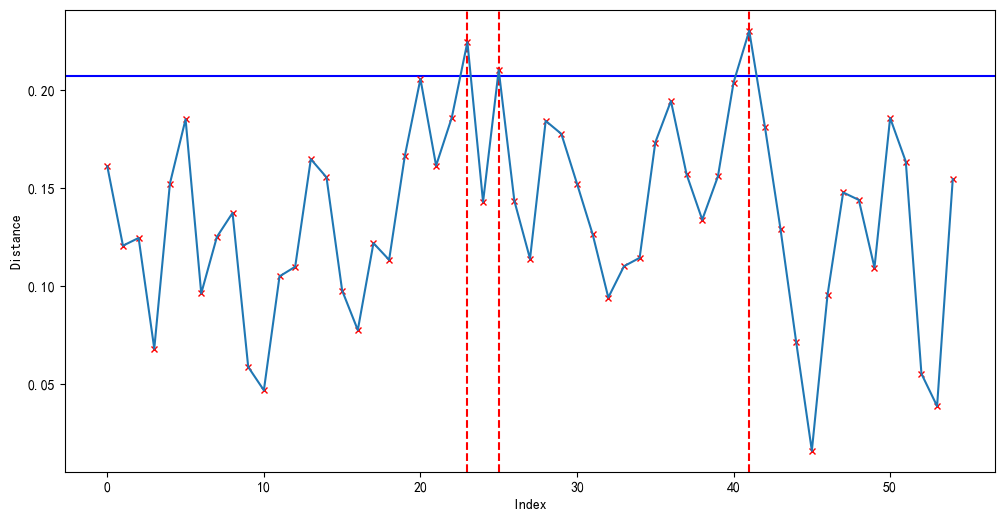

[23 25 41]


In [15]:
o = plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=95)
print(o)

In [17]:
dis = [0.16119427, 0.12062873, 0.12455166, 0.06797375, 0.15239121,
       0.18527588, 0.096216  , 0.12511538, 0.13737667, 0.05862419,
       0.04667495, 0.10492832, 0.10984528, 0.16485972, 0.15556964,
       0.09768085, 0.07748385, 0.1219255 , 0.11336703, 0.16633417,
       0.20590352, 0.16155645, 0.18601509, 0.22468481, 0.14300643,
       0.21043539, 0.143521  , 0.11393298, 0.18443294, 0.17777653,
       0.15230728, 0.12645723, 0.09410162, 0.11009988, 0.11440269,
       0.17335604, 0.19457212, 0.15705317, 0.13389708, 0.15601343,
       0.20401754, 0.2305205 , 0.18148704, 0.12899465, 0.07133264,
       0.01578227, 0.095357  , 0.14783248, 0.14401331, 0.10940427,
       0.1859329 , 0.16362871, 0.05512602, 0.03858535, 0.1546327 ]

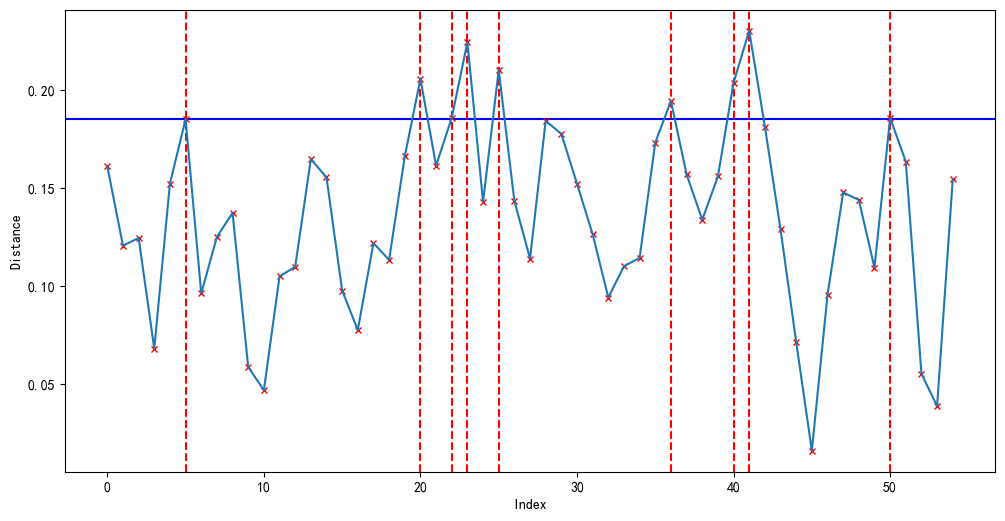

[ 5 20 22 23 25 36 40 41 50]


In [18]:
o = plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=85)
print(o)

In [20]:
def build_semantic_groups(split_texts , breakpoints: List[int]) -> List[str]:
    """
    Constructs semantic groups from text splits using specified breakpoints.

    Args:
        breakpoints (List[int]): A list of indices representing breakpoints.

    Returns:
        List[str]: A list of concatenated text strings for each semantic group.
    """
    start_index = 0
    grouped_texts = []
    # add end criteria
    breakpoints = np.append(breakpoints, [-1])
    for break_point in breakpoints:
        # we're at the end of the text
        if break_point == -1:
            grouped_texts.append(
                " ".join([x for x in split_texts[start_index:]])
            )

        else:
            grouped_texts.append(
                " ".join([x for x in split_texts[start_index : break_point + 1]])
            )

        start_index = break_point + 1

    return grouped_texts

In [21]:
build_semantic_groups(single_sentences_list , plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=95,plot=False))

['云南大学 2020 年本科人才培养方案\n计算机科学与技术专业\n一、专业简介\n云南大学于 1984 年成立了云南省内高校第一个计算机专业，并于 2008 年获云南省唯一\n的计算机类国家级特色专业。 分别于 1998 年和 2000 年获得“计算机软件与理论”和“计算\n机应用技术”二级学科硕士授权点，于 2004年获得“计算机科学与技术”一级学科硕士学位\n授权点，2008 年获得“计算机技术”专业硕士学位授权点，2013 自主设立二级学科硕士点“服\n务科学与工程”，2017 年获得“计算机科学与技术”一级学科博士学位点授权，2019 年获批\n设立“计算机科学与技术”云南省博士后流动站。 2017 年全国第四轮学科评估中，“计算机科\n学与技术”学科评估结果为“B-”，省内该学科排名第一，代表了云南省计算机科学与技术学\n科的最高水平。 2016 年入选云南省八大重点产业引领品牌专业建设项目，2016 年获得云南省\n专业学位研究生联合培养基地建设项目，2017 年入选云南省卓越工程师协同培养计划，2019\n年入选国家级一流本科专业建设点，在西南地区乃至国内具有较高的影响力。 本专业拥有一支学术技术水平高、教学经验丰富的专业师资队伍，专任教师 34 名，其中\n教授 12 人，副教授 9人，博士生导师 8 人，硕士生导师 23 人，云南省中青年学术技术人才 4\n名，60%以上教师具有博士学位。 在数据科学与海量信息处理、多媒体信息处理与视觉计算、\n计算机网络与分布式计算等研究领域，形成了具有鲜明特色的研究方向，学科学术水平得到\n国内外同行的广泛认可。 （一）主干学科：计算机科学与技术\n（二）专业代码：080901\n（三）专业定位：应用型\n（四）学制与学位：基本学制为 4 年，弹性学制为 3-7 年，授予工学学士学位。 1二、培养目标\n本专业培养适应社会与经济发展需要，具有道德文化素养和社会责任感，掌握自然科学\n基础知识，系统地掌握计算机科学理论、计算机软硬件系统及应用知识，具备本领域分析问\n题和解决问题的能力，具备良好的学习能力、实践能力、专业能力和创新意识，可从事计算\n机应用及相关领域中系统研究、设计、开发、制造、应用、维护、管理等工作的复合型高级\n工程技术人才。 本专业毕业的学生经过 5 年左右的职业历练，将达成以下目标：\

##  递归语义切分

与仅仅改变百分位数阈值相比，另一种方法是递归地应用相同的阈值。我们首先在整个文本上创建断点。然后，对于每个新创建的文本块，如果其长度超过某个阈值，就在该文本块内部再次创建断点。这个过程会持续进行，直到所有文本块的长度都低于阈值。

In [22]:
def build_chunks_stack(
    distances, length_threshold: int = 1024, cosine_distance_percentile_threshold: int = 95
) -> np.ndarray:
    
    S = [(0, len(distances))]
    all_breakpoints = set()
    while S:
        id_start, id_end = S.pop()
        distance = distances[id_start:id_end]
        updated_breakpoints = plot_chunk_and_breakpoints(
            distance,
            breakpoint_percentile_threshold=cosine_distance_percentile_threshold,
            plot = False
            
        )
        if updated_breakpoints.size == 0:
            continue  
        updated_breakpoints += id_start
        updated_breakpoints = np.concatenate(
            (np.array([id_start - 1]), updated_breakpoints, np.array([id_end]))
        )
        for index in updated_breakpoints:
            text_group = single_sentences_list[id_start : index + 1]
            total_text = sum(len(text) for text in text_group)
            if (len(text_group) > 2) and (
                total_text >= length_threshold
            ):
                S.append((id_start, index))
            id_start = index + 1
        all_breakpoints.update(updated_breakpoints)

    return np.array(sorted(all_breakpoints))[1:-1]

In [23]:
build_chunks_stack(distances)

array([ 5, 13, 19, 20, 22, 23, 25, 28, 36, 40, 41, 50, 51, 54],
      dtype=int64)

In [24]:
sem_split = build_semantic_groups(single_sentences_list , build_chunks_stack(distances))

In [46]:
sem_split

['云南大学 2020 年本科人才培养方案\n计算机科学与技术专业\n一、专业简介\n云南大学于 1984 年成立了云南省内高校第一个计算机专业，并于 2008 年获云南省唯一\n的计算机类国家级特色专业。',
 '分别于 1998 年和 2000 年获得“计算机软件与理论”和“计算\n机应用技术”二级学科硕士授权点，于 2004年获得“计算机科学与技术”一级学科硕士学位\n授权点，2008 年获得“计算机技术”专业硕士学位授权点，2013 自主设立二级学科硕士点“服\n务科学与工程”，2017 年获得“计算机科学与技术”一级学科博士学位点授权，2019 年获批\n设立“计算机科学与技术”云南省博士后流动站。 2017 年全国第四轮学科评估中，“计算机科\n学与技术”学科评估结果为“B-”，省内该学科排名第一，代表了云南省计算机科学与技术学\n科的最高水平。 2016 年入选云南省八大重点产业引领品牌专业建设项目，2016 年获得云南省\n专业学位研究生联合培养基地建设项目，2017 年入选云南省卓越工程师协同培养计划，2019\n年入选国家级一流本科专业建设点，在西南地区乃至国内具有较高的影响力。 本专业拥有一支学术技术水平高、教学经验丰富的专业师资队伍，专任教师 34 名，其中\n教授 12 人，副教授 9人，博士生导师 8 人，硕士生导师 23 人，云南省中青年学术技术人才 4\n名，60%以上教师具有博士学位。',
 '在数据科学与海量信息处理、多媒体信息处理与视觉计算、\n计算机网络与分布式计算等研究领域，形成了具有鲜明特色的研究方向，学科学术水平得到\n国内外同行的广泛认可。',
 '（一）主干学科：计算机科学与技术\n（二）专业代码：080901\n（三）专业定位：应用型\n（四）学制与学位：基本学制为 4 年，弹性学制为 3-7 年，授予工学学士学位。 1二、培养目标\n本专业培养适应社会与经济发展需要，具有道德文化素养和社会责任感，掌握自然科学\n基础知识，系统地掌握计算机科学理论、计算机软硬件系统及应用知识，具备本领域分析问\n题和解决问题的能力，具备良好的学习能力、实践能力、专业能力和创新意识，可从事计算\n机应用及相关领域中系统研究、设计、开发、制造、应用、维护、管理等工作的复合型高级\n工程技术人才。 本专业毕业的学生经过 5 年左右的职业

In [25]:
cal_desc(sem_split)


Creating 15 chunks
Mean len: 611.8666666666667
Max len: 4020
Sum len: 9178


In [26]:
def plot_chunk_differences_and_breakpoints(
        split_texts: List[str],
        break_points: np.ndarray,
        chunk_cosine_distances: np.ndarray,
    ) -> None:
        """
        Plots the differences and breakpoints of text chunks based on cosine distances.

        Args:
            split_texts (List[str]): A list of text splits.
            break_points (np.ndarray): An array of break point indices.
            chunk_cosine_distances (np.ndarray): An array of cosine distances between text splits.

        Returns:
            None
        """
        cumulative_len = np.cumsum([len(x) for x in split_texts])
        fig = plt.figure(figsize=(20, 6))
        ax = fig.add_subplot(111)

        cosine_dist_min = 0
        cosine_dist_max = 1.1 * max(chunk_cosine_distances)

        ax.plot(cumulative_len[:-1], chunk_cosine_distances)
        ax.plot(cumulative_len[:-1], chunk_cosine_distances, "rx", markersize=5)
        ax.vlines(
            cumulative_len[break_points],
            ymin=cosine_dist_min,
            ymax=cosine_dist_max,
            colors="r",
            linestyles="--",
        )

        ax.set_xlabel("Cumulative characters")
        ax.set_ylabel("Cosine distance between splits")

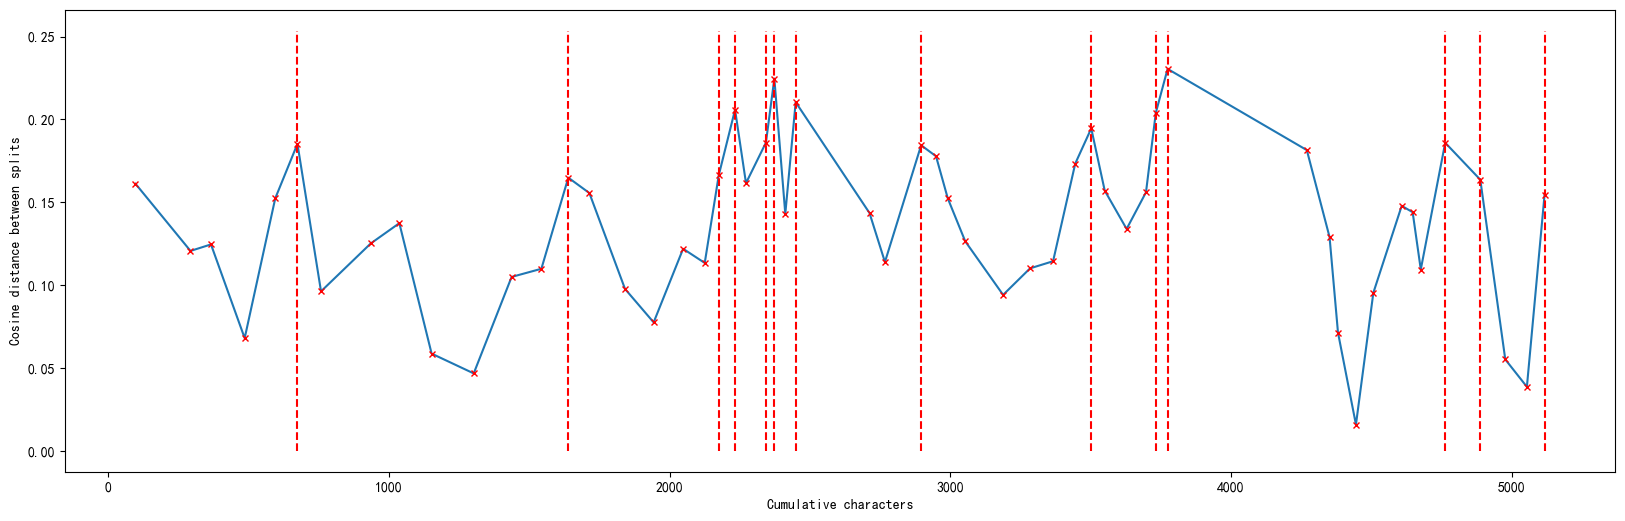

In [27]:
plot_chunk_differences_and_breakpoints(single_sentences_list , build_chunks_stack(distances) , distances)

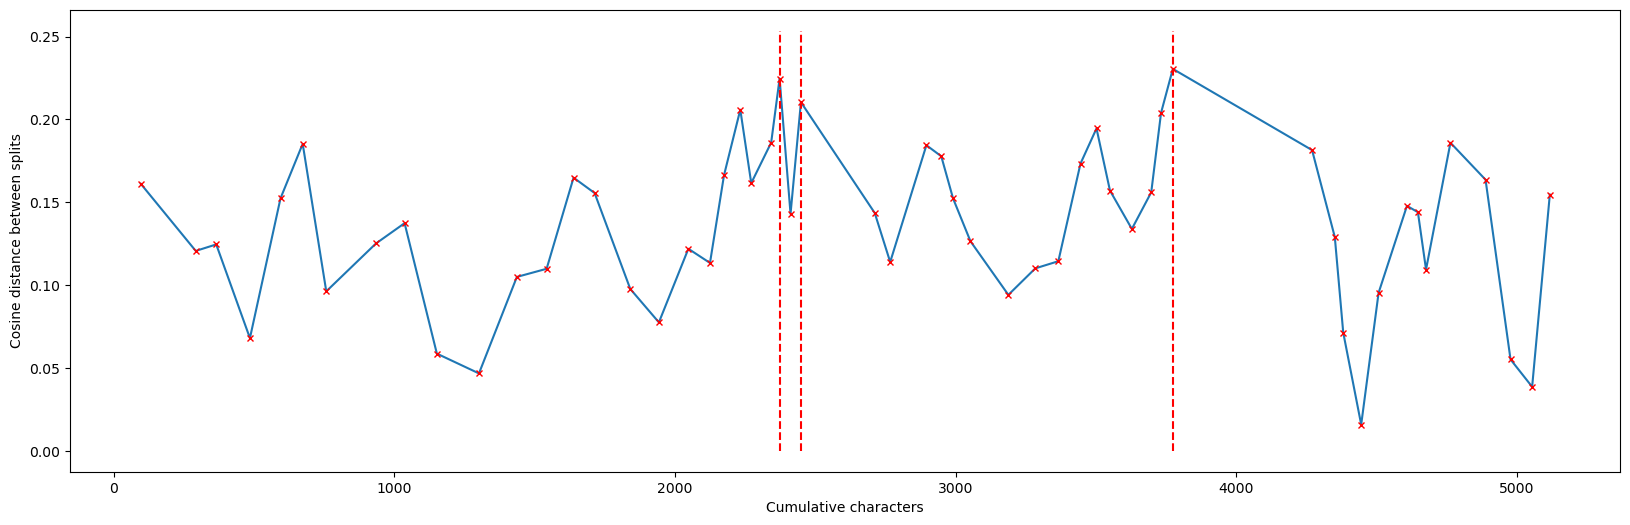

In [37]:
plot_chunk_differences_and_breakpoints(single_sentences_list , plot_chunk_and_breakpoints(distances , breakpoint_percentile_threshold=95 ,plot=False) , distances)

## 如何衡量语义切分是否合理 （可视化）
 - TSNE (降维)
 - Kmeans （聚类）
 - 连线


In [30]:
from sklearn.manifold import TSNE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns

tsne = TSNE(n_components=2 ,  perplexity=5 ,random_state=24)
sentences_embed_np = np.array(sentences_embed)
embeddings_2d = tsne.fit_transform(sentences_embed_np )

## 获取聚类类别

In [31]:
breakpoint_95_rec = build_chunks_stack(distances, cosine_distance_percentile_threshold=85)
updated_breakpoints = np.concatenate(
            (np.array([-1]), breakpoint_95_rec, np.array([len(distances)]))
        )

cdists = np.empty(len(distances) +1 )
for i in range(1,len(updated_breakpoints)):
    cdists[updated_breakpoints[i-1]+1:updated_breakpoints[i]+1] = i-1

In [43]:
res = []
cur_len = 0
cluster = 0
for (idx, sentence) in enumerate(single_sentences_list):
    if cur_len + len(sentence) > 1024:
        cur_len = 0
        res.append(cluster)
        cluster += 1

breakpoint_95_rec = res
updated_breakpoints = np.concatenate(
            (np.array([-1]), breakpoint_95_rec, np.array([len(distances)]))
        )

cdists2 = np.empty(len(distances) +1 )
for i in range(1,len(updated_breakpoints)):
    cdists[updated_breakpoints[i-1]+1:updated_breakpoints[i]+1] = i-1

In [32]:
cdists

array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  2.,  2.,  2.,  2.,  2.,  2.,  3.,  4.,  4.,  5.,  6.,  6.,
        7.,  7.,  7.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9., 10., 10.,
       10., 10., 11., 12., 12., 12., 12., 12., 12., 12., 12., 12., 13.,
       14., 14., 14., 15.])

In [37]:
temp = [[i]*2 for i in range(28)]
cists2 = np.array(temp).flatten()
print(cists2)

[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15 16 16 17 17 18 18 19 19 20 20 21 21 22 22 23 23
 24 24 25 25 26 26 27 27]


In [33]:
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial']  # 优先使用黑体，备选Arial
plt.rcParams['axes.unicode_minus'] = False  # 修复负号显示问题
def clusetr_sentences_plt(n_clusters , cdists):
    """
        Plots the distribution and breakpoints of text chunks based on cosine distances.

        Args:
            n_clusters (int): Total number of clusters (categories) for classification.
            cdists (np.ndarray): An array of indices representing cluster points.
        
        Returns:
            None
    """
    # 使用K-means进行聚类
    kmeans = KMeans(n_clusters=n_clusters, random_state=24)
    y_kmeans = kmeans.fit_predict(embeddings_2d)

    plt.figure(figsize=(6, 6))
    
    colors = sns.color_palette( 'hsv', n_clusters)

    # 绘制每个聚类
    for i in range(n_clusters):
        # 选择当前聚类的所有点
        cluster_points = embeddings_2d[cdists == i]
        
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                    color=colors[i], 
                    label=f'Cluster {i+1}', 
                    s=50, 
                    alpha=0.7)
        
        # 如果聚类中点数大于1，则连接点
        if len(cluster_points) > 1:
            # 按第一个维度排序
            sorted_indices = np.argsort(cluster_points[:, 0])
            sorted_cluster_points = cluster_points[sorted_indices]
            
            plt.plot(sorted_cluster_points[:, 0], 
                    sorted_cluster_points[:, 1], 
                    color=colors[i], 
                    linestyle='-', 
                    linewidth=1, 
                    alpha=0.5)
    # 绘制聚类中心
    centers = kmeans.cluster_centers_
    for center in centers:
        plt.plot(center[0], center[1], 
                marker='x', 
                markersize=20, 
                color='red', 
                markeredgewidth=3 ,
                alpha=0.35)

    plt.xlabel('Dimension 1', fontsize=14)
    plt.ylabel('Dimension 2', fontsize=14)

    # 添加图例，分两列显示
    plt.legend(bbox_to_anchor=(1.05, 1), 
            loc='upper left', 
            borderaxespad=0.,
            ncol=1)

    # 调整布局以显示完整图例
    plt.tight_layout()

    plt.show()

In [ ]:
c = [5 20 22 23 25 36 40 41 50]


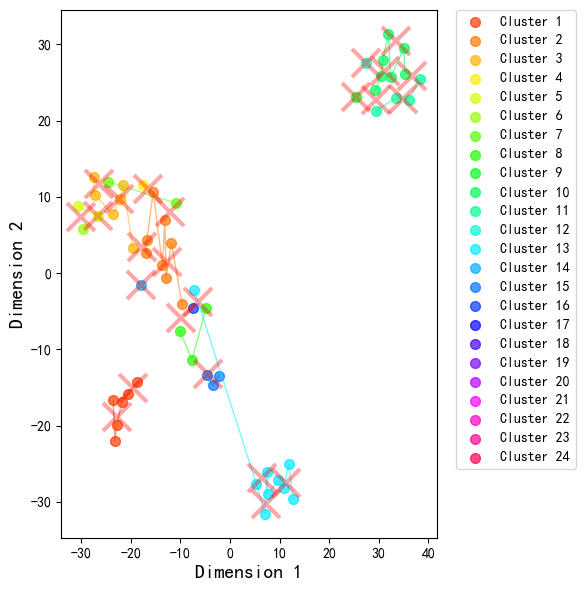

In [34]:
clusetr_sentences_plt(24 , cdists)

In [36]:
ss = '0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6'
print(len(ss.split()))

55


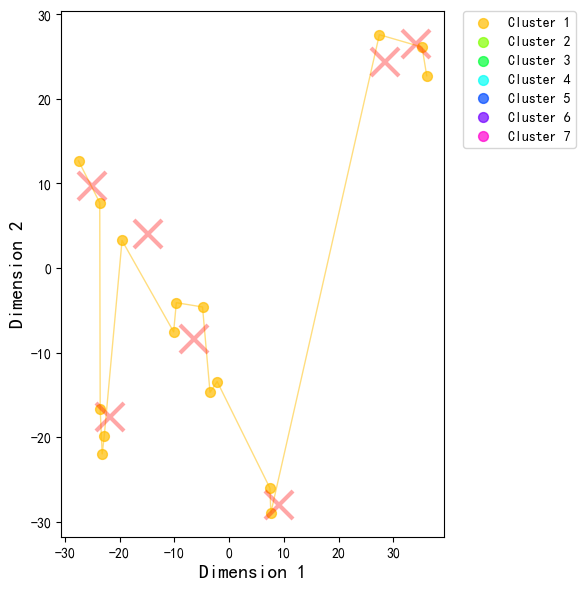

In [44]:


clusetr_sentences_plt(7 , cdists2)

In [41]:
print(len(cdists))
print(len(res))

56
56
